In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import time




In [2]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


In [3]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 Hz a 60000 Hz, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)


N_rot_example = 3e4  
Mass_example = 21  
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")

Interpolação para N_rot=30000.0, Mass=21: -2.22029


In [4]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(8000, 9000)  # MPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(27e3, 5e4)  
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value
            




In [5]:
def ale():
  return np.random.uniform(4000, 5000)



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)

In [6]:
def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3   # m²
    L_c = 2.0      # m
    alpha = 0.5   #  
    P_out = 5.0 
    C1 = 479.029  # Constante
    V_p = 2.0    # m³
    K_nu = 0.38   # kg / (kPa^0.5 s)
    phi = 1.5   # φ
    z = 0 if x[1] < P_out else np.sqrt(x[1]*1e3   - P_out*1e3)

    dmdt = (A1 / L_c) * ((phi * 8.5 - x[1]) *1e3)
    dPdt = ((C1**2/V_p) * (x[0] - alpha * K_nu * z )) 

    return dmdt, dPdt

stati = fsolve(Estacionario, [100, 105])

print(Estacionario(stati))

(np.float64(0.0), np.float64(0.0))


In [7]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0])) 
    
    

    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.5          # Constante Abertura da valvula
    P_out = 5.0          #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38         # kg / (kBar^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1]*1000 - P_out*1000))

    rhs = vertcat(
        (A1 / L_c) * (phi * (p[0]/1000) - x[1] )*1000,    # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha * K_nu * sqrt(x[1]*1000 - P_out*1000))         # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    F = integrator('F', 'cvodes', ode, {'tf': 60, "max_step_size": 10})

    #
    t_eval = np.linspace(0, 60, 600)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9

    #
    for i in range(len(t_eval)):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval



In [8]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []

    for i in range(loops):
        if i == 0:

            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]

        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation,N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total

CasADi - 2024-12-02 14:15:39 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


Tempo de execução: 0.22900700569152832 segundos
Tempo de execução: 0.13480091094970703 segundos
Tempo de execução: 0.14905190467834473 segundos
Tempo de execução: 0.1411447525024414 segundos
Tempo de execução: 0.12844371795654297 segundos
Tempo de execução: 0.1200869083404541 segundos
Tempo de execução: 0.125563383102417 segundos
Tempo de execução: 0.14204835891723633 segundos
Tempo de execução: 0.17968988418579102 segundos
Tempo de execução: 0.24707293510437012 segundos
Tempo de execução: 0.15799188613891602 segundos
Tempo de execução: 0.16685009002685547 segundos
Tempo de execução: 0.18296098709106445 segundos
Tempo de execução: 0.15541625022888184 segundos
Tempo de execução: 0.13119220733642578 segundos
Tempo de execução: 0.18699049949645996 segundos
Tempo de execução: 0.17642903327941895 segundos
Tempo de execução: 0.10290026664733887 segundos
Tempo de execução: 0.14433550834655762 segundos
Tempo de execução: 0.19574737548828125 segundos
Tempo de execução: 0.29843616485595703 segun

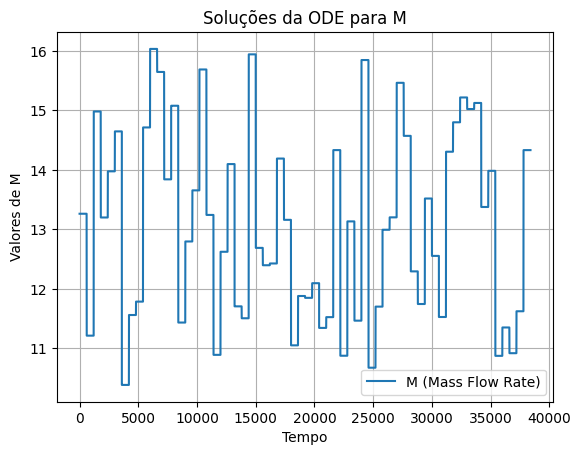

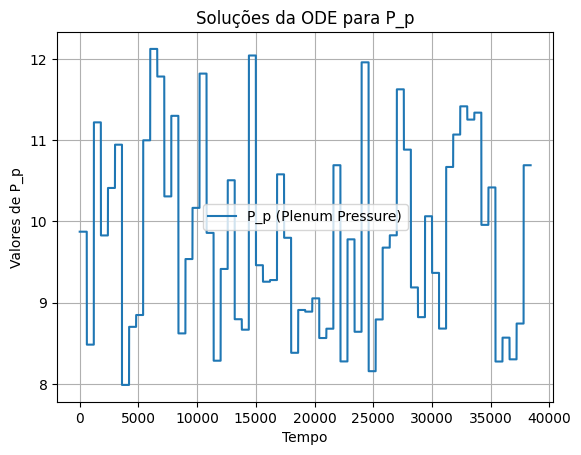

In [9]:

aaaa, PlotP1, PlotN, Plott = Loop(64, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]

# Plotar os resultados
plt.figure()
plt.plot(Ploty[:, 0], label='M (Mass Flow Rate)')
plt.xlabel('Tempo')
plt.ylabel('Valores de M')
plt.title('Soluções da ODE para M')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(Ploty[:, 1], label='P_p (Plenum Pressure)')
plt.xlabel('Tempo')
plt.ylabel('Valores de P_p')
plt.title('Soluções da ODE para P_p')
plt.legend()
plt.grid(True)
plt.show()




In [10]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result


# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value

    return result

In [11]:
# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]




In [12]:
from matplotlib.pyplot import scatter, figure

In [13]:

X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)

# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [20]:
from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator


In [35]:


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        # LSTM bidirecional
        #self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm = BayesianLSTM(input_dim, hidden_dim, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.activation = nn.Tanh()
        
        # Camadas lineares
        self.fc1 = nn.Linear(hidden_dim , hidden_dim)  # 2 * hidden_dim por ser bidirecional
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim//2, 2)  # Saída intermediária para entrada em mu e var
        
        # Camadas para estimativa de média (mu) e variância (var)
        self.mu = nn.Linear(2, output_dim)
        self.var = nn.Linear(2, output_dim)

    def forward(self, x):
        # Processamento através da LSTM
        _, (h_n, _) = self.lstm(x)
       # h_n = h_n.transpose(0, 1).reshape(-1, h_n.size(2) * 2)  # Concatenar saídas bidirecionais
        
        # Passagem pelas camadas lineares com dropout
        #x = self.dropout(h_n)
        x = self.activation(self.fc1(h_n))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        # Estimar média (mu) e variância (var)
        mu = self.mu(x)
        var = torch.exp(self.var(x))  
        
        return x

    

    

In [22]:
input_dim = X_train_tensor.shape[2]
output_dim = y_train_tensor.shape[1]
batch_size = 128
n_epochs = 150




train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [23]:
import optuna 
from optuna.trial import TrialState

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    hidden_dim = trial.suggest_int("hidden_dim", 100, 130)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    return loss.item()



# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize') #sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize



[I 2024-12-02 14:16:28,473] A new study created in memory with name: no-name-ec07222e-1244-4efe-9fda-53161b7ca448


<bound method Study.optimize of <optuna.study.study.Study object at 0x00000284ABBE5F10>>

In [36]:

study.optimize(objective, n_trials=10)

# Imprimir o melhor conjunto de hiperparâmetros

print(study.best_params)

[I 2024-12-02 14:34:36,352] Trial 5 finished with value: 1.442041411792161e-05 and parameters: {'dropout_rate': 0.20732689382728237, 'hidden_dim': 120, 'learning_rate': 0.00010927665504968649}. Best is trial 5 with value: 1.442041411792161e-05.
[I 2024-12-02 14:45:13,881] Trial 6 finished with value: 0.001283089048229158 and parameters: {'dropout_rate': 0.22021582943990234, 'hidden_dim': 130, 'learning_rate': 0.00017892278564488254}. Best is trial 5 with value: 1.442041411792161e-05.
[I 2024-12-02 14:55:14,590] Trial 7 finished with value: 4.58858376077842e-05 and parameters: {'dropout_rate': 0.32013952306312776, 'hidden_dim': 127, 'learning_rate': 0.00015410660726810477}. Best is trial 5 with value: 1.442041411792161e-05.
[I 2024-12-02 15:04:32,526] Trial 8 finished with value: 0.0014633953105658293 and parameters: {'dropout_rate': 0.3557862233859701, 'hidden_dim': 110, 'learning_rate': 0.000655476844270056}. Best is trial 5 with value: 1.442041411792161e-05.
[I 2024-12-02 15:15:57,16

{'dropout_rate': 0.20732689382728237, 'hidden_dim': 120, 'learning_rate': 0.00010927665504968649}


In [39]:
test_losses = []
val_losses = []
best_loss = float('inf')
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()
for epoch in range(n_epochs):
    # Loop de treinamento
    for batch in train_loader:
        x = batch[0]
        y = batch[1]
        optimizer.zero_grad()
        mu, var = model(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()

    # Test loop
    if epoch % 10 == 0:
        model.eval()
        all_test_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0]
                y = batch[1]
                mu, var = model(x)
                all_test_losses.append(criterion(mu, y, var).item())
        test_loss = sum(all_test_losses) / len(all_test_losses)
        test_losses.append(test_loss)
        make_plot(model, X_train_tensor, y_train_tensor)
    # Validação
    model.eval()
    with torch.no_grad():
        batch_val_losses = []
        for X_val, y_val in test_loader:
            mu, var = model(X_val)
            batch_val_losses.append(criterion(mu, y_val, var).item())
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        print("BEST MODEL")
        best_model = model.state_dict()

    # Log
    print(f"Epoch {epoch} | Train Loss: {loss.item()} | Test Loss: {test_loss} | Variance: {var.mean().item()}")


NameError: name 'hidden_dim' is not defined

In [ ]:
best_params = study.best_params
# Definir parâmetros do modelo
hidden_dim = best_params['hidden_dim']
dropout_rate =  best_params['dropout_rate']
learning_rate = best_params['learning_rate']

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = torch.nn.GaussianNLLLoss(eps=1e-1) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.eval()
print(best_params)

ValueError: No trials are completed yet.

In [40]:
test_losses = []
val_losses = []
best_loss = float('inf')

model.train()
for epoch in range(n_epochs):
    # Loop de treinamento
    for batch in train_loader:
        x = batch[0]
        y = batch[1]
        optimizer.zero_grad()
        mu, var = model(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()

    # Test loop
    if epoch % 10 == 0:
        model.eval()
        all_test_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0]
                y = batch[1]
                mu, var = model(x)
                all_test_losses.append(criterion(mu, y, var).item())
        test_loss = sum(all_test_losses) / len(all_test_losses)
        test_losses.append(test_loss)
        make_plot(model, X_train_tensor, y_train_tensor)
    # Validação
    model.eval()
    with torch.no_grad():
        batch_val_losses = []
        for X_val, y_val in test_loader:
            mu, var = model(X_val)
            batch_val_losses.append(criterion(mu, y_val, var).item())
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        print("BEST MODEL")
        best_model = model.state_dict()

    # Log
    print(f"Epoch {epoch} | Train Loss: {loss.item()} | Test Loss: {test_loss} | Variance: {var.mean().item()}")


NameError: name 'model' is not defined

In [ ]:
# Carregar o melhor modelo salvo
model.eval()


LSTMModel(
  (lstm): LSTM(4, 104, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3394633936788146, inplace=False)
  (activation): Tanh()
  (fc1): Linear(in_features=208, out_features=104, bias=True)
  (fc2): Linear(in_features=104, out_features=52, bias=True)
  (fc3): Linear(in_features=52, out_features=52, bias=True)
  (fc4): Linear(in_features=52, out_features=2, bias=True)
  (mu): Linear(in_features=2, out_features=2, bias=True)
  (var): Linear(in_features=2, out_features=2, bias=True)
)

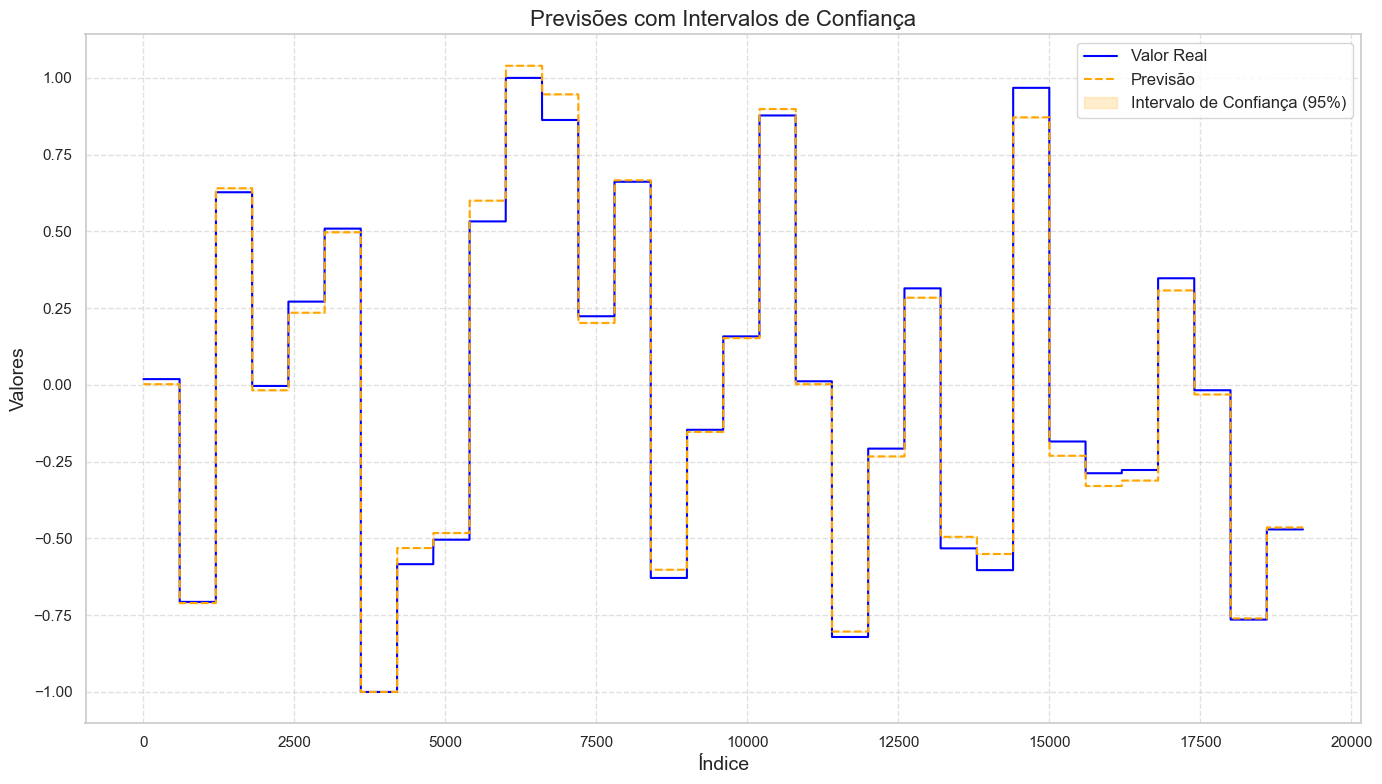

In [ ]:

model.load_state_dict(best_model)
make_plot(model, X_train_tensor, y_train_tensor)

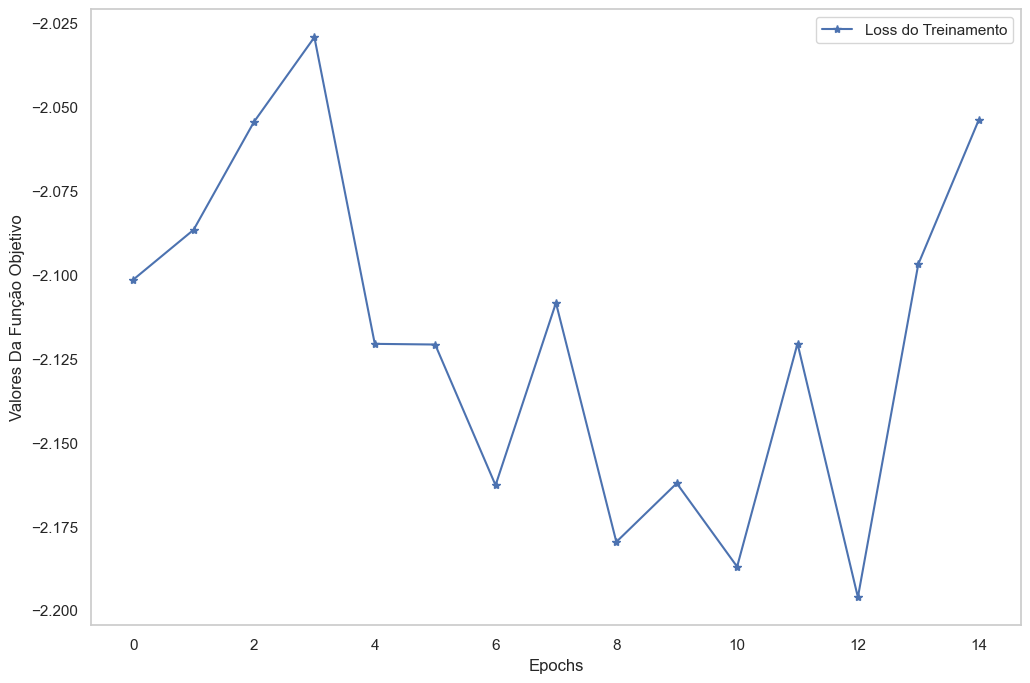

In [ ]:
plt.plot(test_losses, marker="*", label='Loss do Treinamento')
#plt.plot(val_losses, label='Loss de Validação')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Valores Da Função Objetivo')
plt.grid()
plt.show()

In [ ]:
# Carregar o melhor modelo salvo

#model.load_state_dict(model)
tempos = []

# Avaliação final com o conjunto de teste
model.eval()
with torch.no_grad():

    for i in range (10000):
        start = time.time()
        y_test_pred, var  = model(X_test_tensor)
        end = time.time()
        print(f"Tempo de execução: {end - start} segundos")
        test_loss = criterion(y_test_pred, y_test_tensor, var)
        tempo = end - start
        tempos.append(tempo)
        #print(f"Teste Loss: {test_loss.item()}")


Tempo de execução: 0.3018500804901123 segundos
Tempo de execução: 0.25580906867980957 segundos
Tempo de execução: 0.3314189910888672 segundos
Tempo de execução: 0.2778446674346924 segundos
Tempo de execução: 0.26973724365234375 segundos
Tempo de execução: 0.23295164108276367 segundos
Tempo de execução: 0.20219802856445312 segundos
Tempo de execução: 0.18309760093688965 segundos
Tempo de execução: 0.1816694736480713 segundos
Tempo de execução: 0.20402169227600098 segundos
Tempo de execução: 0.19811558723449707 segundos
Tempo de execução: 0.1807389259338379 segundos
Tempo de execução: 0.21312260627746582 segundos
Tempo de execução: 0.1975870132446289 segundos
Tempo de execução: 0.20136308670043945 segundos
Tempo de execução: 0.1860182285308838 segundos
Tempo de execução: 0.19661188125610352 segundos
Tempo de execução: 0.18750309944152832 segundos
Tempo de execução: 0.19620442390441895 segundos


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
default_dpi = 96
time_x = np.arange(len(tempos))
tempos = tempos
print(tempos)
def save_or_show(filename: str | None = None):
    if filename is None:
        plt.show()
    else:
        plt.savefig(save_folder + filename)
        plt.clf()
        plt.close()

[0.5665907859802246, 0.442324161529541, 0.33379411697387695, 0.34444451332092285, 0.33178210258483887, 0.33348846435546875, 0.34149789810180664, 0.3169066905975342, 0.3334500789642334, 0.33333420753479004, 0.34474992752075195, 0.34610724449157715]


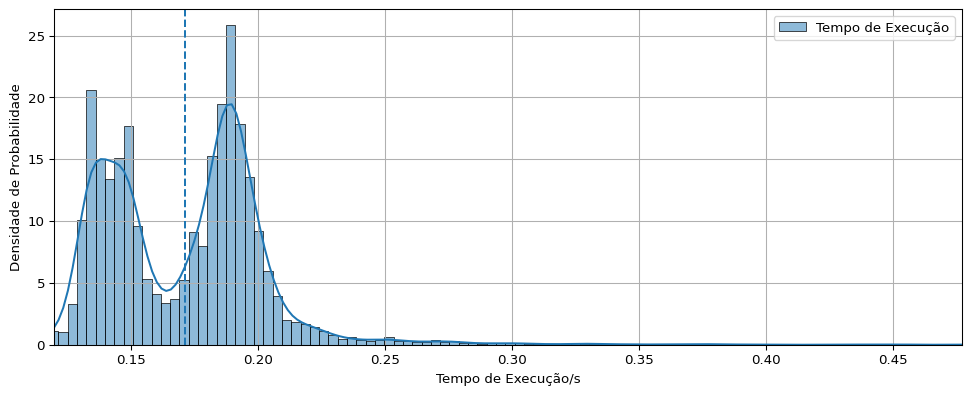

In [ ]:
def plot_density(values, labels, metric, filename: str | None = None):
    plt.figure(figsize=(10, 4), layout="constrained", dpi=default_dpi)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for i in range(len(values)):
        sns.histplot(
            values[i],
            kde=True,
            label=labels[i],
            stat="density",
            bins=100,
            color=colors[i],
        )

        mean_value = np.mean(values[i])
        plt.axvline(
            mean_value,
            linestyle="--",
            linewidth=1.5,
            color=colors[i],
        )

    plt.xlabel(metric)
    plt.xlim(0.12, max(values[0]))
    plt.ylabel("Densidade de Probabilidade")
    plt.grid()
    plt.legend()

plot_density([tempos], ["Tempo de Execução"], "Tempo de Execução/s")

Tempo de execução: 0.34700560569763184 segundos
tensor([[5.2373e-09, 3.8952e-10],
        [5.7318e-09, 4.3171e-10],
        [5.7318e-09, 4.3171e-10],
        ...,
        [5.0883e-13, 1.0505e-14],
        [5.0883e-13, 1.0505e-14],
        [5.0883e-13, 1.0505e-14]])


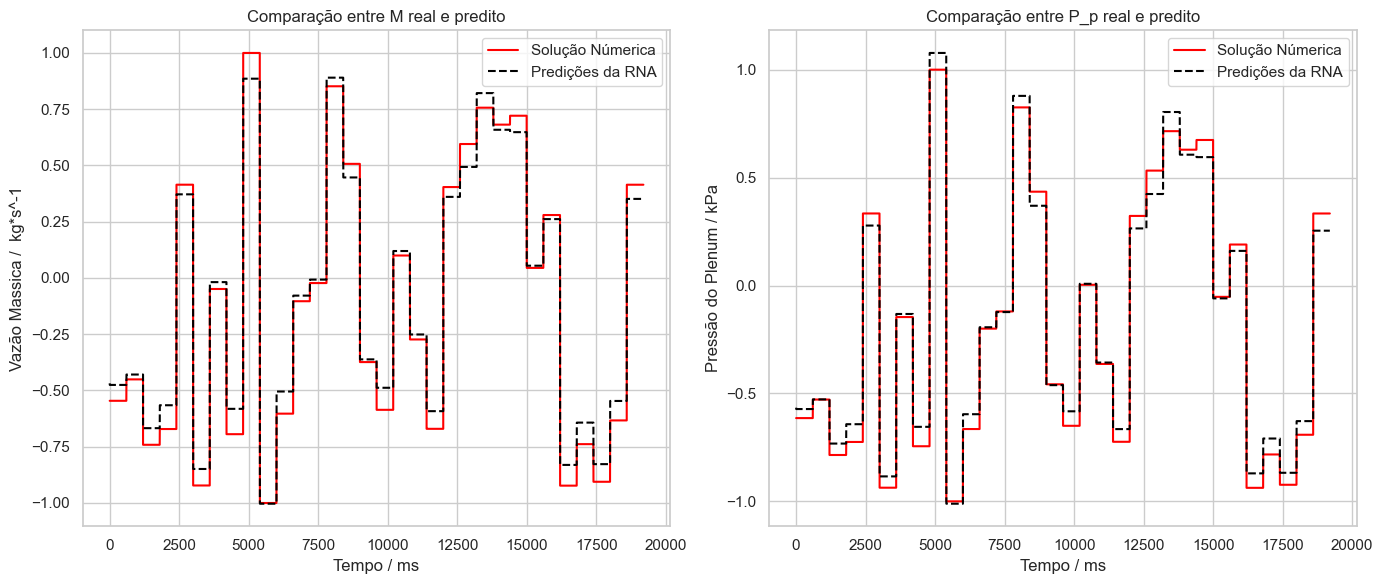

In [ ]:


with torch.no_grad():

    
    start = time.time()
    y_test_pred, var = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = criterion(y_test_pred, y_test_tensor, var)
    

print(var)
y_test_pred_original = y_test_pred
y_test_original = y_test



plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(y_test_original[:, 1], label="Solução Númerica" ,color="red")
plt.plot(y_test_pred_original[:, 1], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


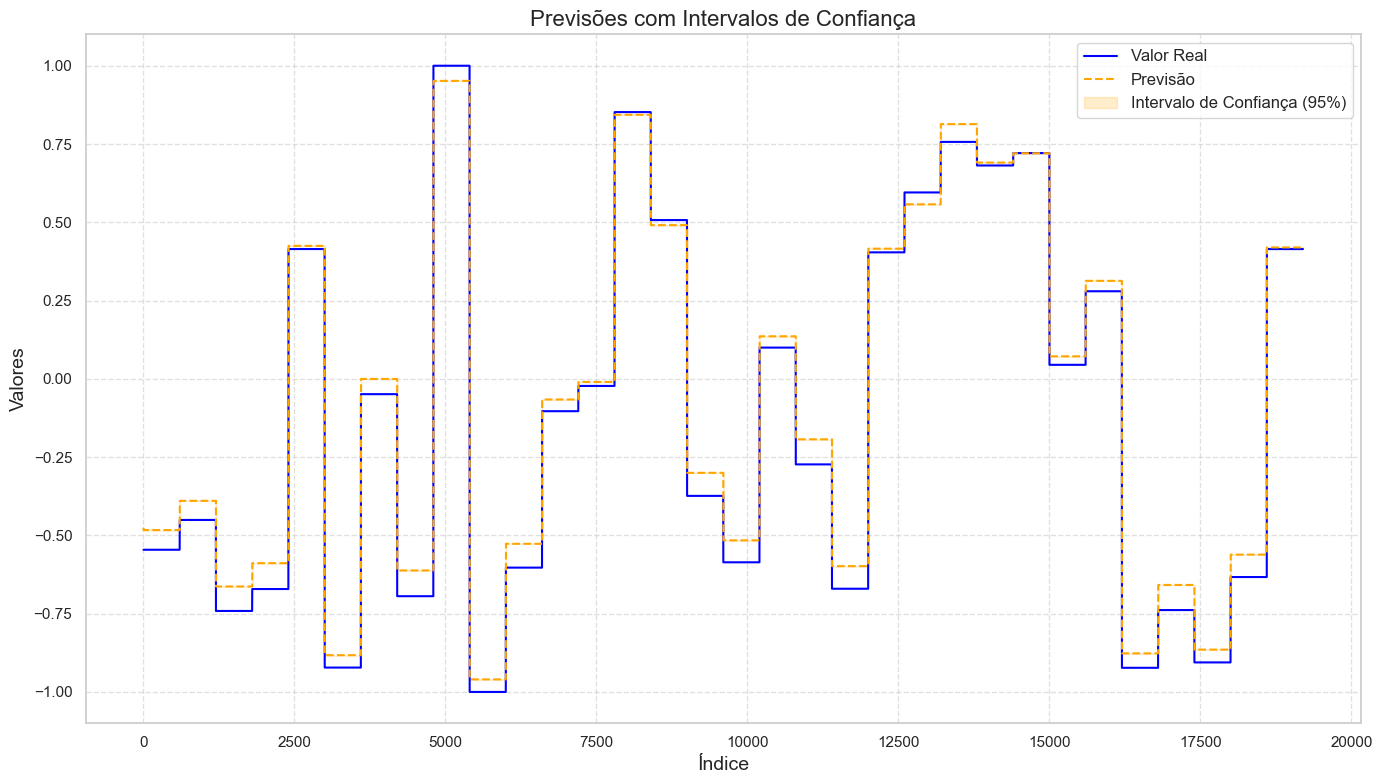

In [ ]:
make_plot(model, X_test_tensor, y_test_tensor)

